In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

Questions Andreas:
- How is Epsilon updated?

In [3]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [4]:
data = pd.read_csv('../../data/covid19model.csv')

In [7]:
def trunc_exponential(scale, upper):
    sample = torch.distributions.exponential.Exponential(1/scale).rsample()
    sample = sample/torch.tensor(1-torch.exp(-upper/scale))
    return sample
# torch.distributions.exponential.Exponential(1/scale).sample()/torch.tensor(1-torch.exp(-upper/scale))

def trunc_normal(mu, sigma, under, upper):
    distribution = torch.distributions.normal.Normal(loc=mu, scale=sigma, validate_args=None)
    normal_sample = distribution.rsample()
    cumulative = distribution.cdf(torch.tensor(upper)) - distribution.cdf(torch.tensor(under))
    return normal_sample/cumulative

# Initialization


In [9]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [11]:
"""tau = np.random.exponential(1 / 0.03)
tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)"""


tau= torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

This is a way to generate the initial params from pytorch distribution directly without truncation.
NOTE: Use either this code block below or above.

In [12]:
dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))
#tau_t = dist_tau_t.sample()

dist_y = distributions.exponential.Exponential(tau)
#y = dist_y.sample()

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
#phi = dist_phi.sample()

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
#R0 = dist_R0.sample()

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
#alpha = dist_alpha.sample()

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))
#sigma = dist_sigma.sample()

In [13]:
#epsilon_t = torch.randn(num_observations, requires_grad=True, device=device, dtype=dtype)
epsilon_t = torch.zeros(num_observations, device=device)

In [16]:
epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
for t in range(1, num_observations):
  epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()

# Define Forward Pass

In [18]:
def forward_pass():
  epsilon_t.retain_grad()
  # Initialize time series variables
  y = trunc_exponential(tau, 1000)
  newly_infected = torch.zeros(num_observations, device=device)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected
  eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
  #epsilon_t = torch.zeros(num_observations, device=device)  # random walk
  St = torch.zeros(num_observations, device=device)  # fraction of susceptible population

  # log likelihood wrt. our prior ("regularisation")
  # ll stands for log-likelihood
  ll = torch.tensor(0.0, device=device)

  #dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03]))
  ll += dist_tau_t.log_prob(tau).item()

  #dist_y = distributions.exponential.Exponential(tau) #the parameter in the brasket should either be float or tensor, to avoid any inconvienience,
                                                      # I use everything as tensor. NOTE:tau_t is already a tensor.
  #ll += dist_y.log_prob(y).item()

  #dist_phi = distribution.normal.Normal(loc=torch.tensor([25]), scale=torch.tensor([10]))
  ll += dist_phi.log_prob(phi).item()

  #dist_R0 = distribution.normal.Normal(loc=torch.tensor([3.6]), scale=torch.tensor([0.8]))
  ll += dist_R0.log_prob(R0).item()

  #dist_alpha = distribution.normal.Normal(loc=torch.tensor([0.01]), scale=torch.tensor([0.01]))
  ll += dist_alpha.log_prob(alpha).item()

  #dist_sigma = distribution.normal.Normal(loc=torch.tensor([0.1]), scale=torch.tensor([0.3]))
  #ll += dist_sigma.log_prob(sigma).item()


  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  # basic reproduction number as a latent random walk
  beta_0 = torch.log(R0)
  eta_t[0] = beta_0
  #epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
  for t in range(1, num_observations):
      #epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
      dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
      ll += dist_epsilon_t.log_prob(epsilon_t[t - 1]).item() #epsilon_t.log_prob(epsilon_t[t - 1]) ---> Andreas: whats the correct regularization - epsilon or eta? 
  eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations-1].clone() # 	--> Andreas:	ηt[t] = ϵt[t-1] # + RNN[X_t, t] - add beta_0 to all values or only equals eta_t[0] 
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals

      for i in range(0, t-1): # correct range or change to (0, t) ?
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()
      newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      for i in range(0, t):
          expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
  expected_daily_hospit = alpha * expected_daily_hospit

  # compare observed hospitalizations to model results
  # likelihood of the data wrt. to the model

  for i in range(0, num_observations):

      p = 1/(1+ expected_daily_hospit[i]/phi)
      dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p-torch.tensor(2.225e-5))
      ll += dist.log_prob(observed_daily_hospit[i])


  return expected_daily_hospit, Rt, ll

# Optimization

<ipython-input-7-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))
<ipython-input-7-2bb73561946a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))


Time Step: 0, Loss: 91749.828125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 57286.015625
|| Learning Rate: 0.0001, R0:3.204308148969499, grad: -3587.899115975264, alpha: 0.010003468065372795 grad: -610356.5, phi: 34.738251064716415 grad: 2954.2613562484567, epsilon_t.mean: 1.9244096279144287 grad.mean -28.24750518798828
This Run:  30.31880283355713 seconds
Time Step: 1, Loss: 88042.6953125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 57890.58984375
|| Learning Rate: 0.0001, R0:3.2046669388810964, grad: -12009.782076117335, alpha: 0.010064503715372795 grad: -615005.625, phi: 34.73795563858079 grad: 2848.944067436659, epsilon_t.mean: 1.9272345304489136 grad.mean -94.56351470947266
This Run:  32.74519729614258 seconds
Time Step: 2, Loss: 90637.8125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 58194.546875
|| Learning Rate: 0.0001, R0:3.205867917088708, grad: -5390.255529091669, alpha: 0.010126004277872795 grad: -610049.875, phi: 34.737670744174046 grad: 

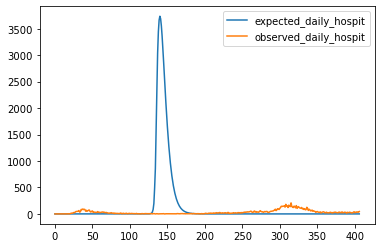

KeyboardInterrupt: 

In [19]:
learning_rate = 1e-4
complete_time = time.time()

for k in range (400):
    start_time = time.time()
    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll = forward_pass()

    #backward pass
    loss = -ll
    loss.backward()

    print(f'Time Step: {k}, Loss: {loss}, Observed_daily_hospit: {torch.sum(observed_daily_hospit)}, Expected_daily_hospit: {torch.sum(expected_daily_hospit)}')
    print(f'|| Learning Rate: {learning_rate}, R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, phi: {phi} grad: {phi.grad}, epsilon_t.mean: {epsilon_t.mean()} grad.mean {epsilon_t.grad.mean()}') # , sigma: {sigma} grad {sigma.grad}'  , 

    with torch.no_grad(): # this part is SGD. can also replace with loss.step
        tau -= learning_rate * tau.grad
        phi -= learning_rate * phi.grad * 1e-3
        R0 -= learning_rate * R0.grad * 1e-3
        alpha -= learning_rate * alpha.grad * 1e-6
        #sigma -= learning_rate * sigma.grad * 1e-6
        epsilon_t -= learning_rate * epsilon_t.grad

        tau.grad = None
        phi.grad = None
        R0.grad = None
        alpha.grad = None
        #sigma.grad = None
        epsilon_t.grad = None

    epsilon_t = epsilon_t.detach()
    epsilon_t.requires_grad_(True)
    tau = tau.detach()
    tau.requires_grad_(True)

        
    print("This Run:  %s seconds" % (time.time() - start_time))
    if k%10 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))